# End-To-End Training Example of RNN for rain estimation and detection using PyNNCML
This notebook presents an end-to-end example of training a Recurrent Neural Network (RNN) based rain estimation neural network [1] on the openMRG dataset.
This tutorial is built using the PyNNCML software package, which provides both tools to simplify the training process of deep learning models for CMLs.
We start with obtaining a subset of the OpenMRG dataset and splitting it into training and validation datasets.
Afterward, we construct the One Step Network from [1], followed by the training loop.
Finally, we analyze the model performance in terms of RMSE and Bias.


Notebook structure
1. Imports and Installation of PyNNCML
2. Hyperparameter settings
3. Build Dataset
4. Build Neural Network
5. Training Loop
6. Neural Network Analysis


[Run this notebook in colab](https://colab.research.google.com/github/haihabi/PyNNcml/blob/master/examples/training_rnn.ipynb)

To run this notebook on Colab using GPU, please do the following:
Runtime -> Change runtime type -> Select GPU -> Save


In [ ]:
! pip install prettytable

In [ ]:
import sys
import os

if os.path.exists('../pynncml'):
    print("Import PyNNCML From Code")
    sys.path.append('../')  # This line is need to import pynncml
# else:
#     print("Install PyNNCML From pip")
#     !pip install pynncml

import numpy as np
import pynncml as pnc
import torch
import math
from matplotlib import pyplot as plt
from tqdm import tqdm

[This repository includes an example of a dataset with a reference rain gauge. In addition, this repository provide PyTorch version of the OpenMRG dataset [10].](https://github.com/pengqianhan/PyNNcml-pq/tree/main)

In OpenMRG: Open data from Microwave links, Radar, and
Gauges for rainfall quantification in Gothenburg, Sweden


1.   study period (June–August 2015)
2.   



在loaders.py 里面


1.   if time_slice is not None:### 选择时间段
    ds = ds.sel(time=time_slice)
    根据这句是不是time_slice ==None 就是默认选择全部时间段呢
2.   if xy_min is None or xy_max is None: 根据这句，如果xy_min 和xy_max 是None 的话是不是就是选择了全部区域呢






In [ ]:
batch_size = 16
window_size = 32
lr = 1e-4
n_epochs = 200
xy_min = [1.29e6, 0.565e6]  # Link Region
xy_max = [1.34e6, 0.5875e6]
time_slice = slice("2015-06-01", "2015-06-10")  # Time Interval
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Building Training and Validation datasets

File already exists at desired location ./data/OpenMRG.zip
Not downloading!


100%|██████████| 728/728 [00:17<00:00, 41.20it/s]


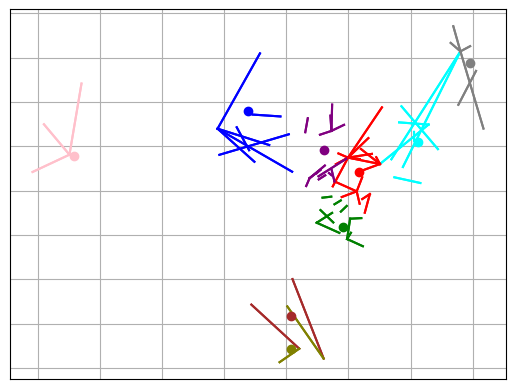

Training Dataset Size: 106
Validation Dataset Size: 26


In [ ]:
dataset = pnc.datasets.loader_open_mrg_dataset(xy_min=xy_min, xy_max=xy_max, time_slice=time_slice)
# dataset = pnc.datasets.loader_open_mrg_dataset()
dataset.link_set.plot_links()
plt.grid()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()
torch.manual_seed(1337)##
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
data_loader = torch.utils.data.DataLoader(training_dataset, batch_size)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size)


In [ ]:
print("Training Dataset Size:", len(training_dataset))##108
print("Validation Dataset Size:", len(validation_dataset))##26

Training Dataset Size: 108
Validation Dataset Size: 26


In [ ]:
# # xy_min = [1.29e6, 0.565e6]  # Link Region
# # xy_max = [1.34e6, 0.5875e6]
# # time_slice = slice("2015-06-01", "2015-06-10")  # Time Interval
# print("Training Dataset Size:", len(training_dataset))##106
# print("Validation Dataset Size:", len(validation_dataset))##26

Training Dataset Size: 106
Validation Dataset Size: 26


In [ ]:
print("Training Dataset Size:", len(training_dataset))##108
print("Validation Dataset Size:", len(validation_dataset))##26

Training Dataset Size: 108
Validation Dataset Size: 26


# Neural Network

In [ ]:
model = pnc.scm.rain_estimation.one_step_network(n_layers=2,
                                                 rnn_type=pnc.neural_networks.RNNType.GRU,
                                                 normalization_cfg=pnc.training_helpers.compute_data_normalization(
                                                     data_loader),
                                                 rnn_input_size=180,
                                                 rnn_n_features=128,
                                                 metadata_input_size=2,
                                                 metadata_n_features=32,
                                                 pretrained=False).to(device)

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertConfig

class TransformerTimeSeriesModel(nn.Module):
    def __init__(self, input_size, output_size, window_size, hidden_size=768, num_heads=12, num_layers=3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.window_size = window_size

        # Create a custom BERT configuration
        config = BertConfig(
            hidden_size=hidden_size,
            num_hidden_layers=num_layers,
            num_attention_heads=num_heads,
            intermediate_size=hidden_size * 4,
            max_position_embeddings=window_size,
        )

        # Initialize the BERT model with our custom configuration
        self.bert = BertModel(config)

        # Input projection layer
        self.input_proj = nn.Linear(input_size, hidden_size)

        # Output projection layer
        self.output_proj = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [batch_size, window_size, input_size]
        batch_size, seq_len, _ = x.size()

        # Project input to hidden size
        x = self.input_proj(x)  # Shape: [batch_size, window_size, hidden_size]

        # Pass through BERT
        outputs = self.bert(inputs_embeds=x)
        last_hidden_state = outputs.last_hidden_state  # Shape: [batch_size, window_size, hidden_size]

        # Project to output size
        output = self.output_proj(last_hidden_state)  # Shape: [batch_size, window_size, output_size]

        return output

# Usage example
input_size = 180  # num_features
output_size = 1  # Assuming you want to predict a single value per time step
window_size = 32
batch_size = 16

t_model = TransformerTimeSeriesModel(input_size, output_size, window_size).to(device)

# Generate random input data
x = torch.randn(batch_size, window_size, input_size)

# Forward pass
output = t_model(x)
print(f"Output shape: {output.shape}")  # Should be [16, 32, 1]

Output shape: torch.Size([16, 32, 1])


# Training Loop

In [ ]:
opt = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=1e-4)
loss_function = torch.nn.MSELoss()
ra = pnc.analysis.ResultsAccumulator()
am = pnc.analysis.AverageMetric()
model.train()
print("Start Training")
n_epochs = 1
for epoch in tqdm(range(n_epochs)):
    am.clear()
    for rain_rate, rsl, tsl, metadata in data_loader:
        state = model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        for step in range(m_step):
            opt.zero_grad()
            # print('rsl shape:',rsl.shape)##[batch_size=16, 958, 90]
            # print('tsl shape:',tsl.shape)##[batch_size=16, 958, 90]
            # print('metadata shape:',metadata.shape)##[16,2]
            # print('rain_rate.shape',rain_rate.shape)##[16,958]
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            # print('_rr.shape',_rr.shape)##[batch_size=16,window_size=32]# it is the label
            # print('_rsl.shape',_rsl.shape)##[batch_size=16, window_size=32, 90]
            # print('_tsl.shape',_tsl.shape)##[batch_size=16, window_size=32, 90]
            ##torch.cat([_rsl, _tsl], dim=-1) shape is [batch_size=16, window_size=32, 90+90]
            # print('metadata shape:',metadata.shape)## [batch_size=16,2]
            rain_hat, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device), state.detach())
            rain_hat = t_model(torch.cat([_rsl, _tsl], dim=-1))
            # print('rain_hat_t.shape',rain_hat.shape)##[batch_size=16,window_size=32,1]
            # print('rain_hat.shape',rain_hat.shape)##[batch_size=16,window_size=32,1]
            loss = loss_function(rain_hat.squeeze(dim=-1), _rr)
            loss.backward()
            am.add_results(loss=loss.item())
            opt.step()
    ra.add_results(loss=am.get_results("loss"))

Start Training


  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
plt.plot(ra.get_results("loss"))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Model Validation

In [ ]:
model.eval()

for rain_rate, rsl, tsl, metadata in val_loader:
    state = model.init_state(batch_size=rsl.shape[0])
    m_step = math.floor(rain_rate.shape[1] / window_size)
    am.clear()
    rain_hat_list = []
    rain_ref_list = []
    for step in range(m_step):
        _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
        _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
        _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
        rain_hat, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device), state.detach())
        rain_hat_list.append(rain_hat.detach().cpu().numpy())
        rain_ref_list.append(_rr.detach().cpu().numpy())
        delta = rain_hat.squeeze(dim=-1) - _rr
        bias = torch.mean(delta)
        mse = torch.mean(delta ** 2)
        am.add_results(bias=bias.item(), mse=mse.item())
print("Validation Results of One-Step RNN")
print("Bias[mm/hr]:", am.get_results("bias"))
print("RMSE[mm/hr]:", np.sqrt(am.get_results("mse")))

In [ ]:
rain_hat_array = np.concatenate(rain_hat_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)

plt.plot(np.maximum(rain_hat_array[0, :, 0], 0), label="One-Step RNN")
plt.plot(rain_ref_array[0, :], label="Reference")
plt.grid()
plt.ylabel("Rain-Rate[mm/hr]")
plt.xlabel("# Samples")
plt.show()